In [ ]:
import pandas as pd
import numpy as np
from plotnine import * 
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas_datareader as pdr

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.api import ExponentialSmoothing
from mizani.breaks import date_breaks
from mizani.formatters import date_format

# **CASE 1: DOMESTIC FLIGHT DATA**

**DATA PREPARATION**

In [ ]:
# Scraping data from website
url = 'https://www.transtats.bts.gov/Data_Elements.aspx?Data=1'
df = pd.read_html(url)
df = df[9]

In [ ]:
df.head()

,Year,Month,DOMESTIC,INTERNATIONAL,TOTAL
0,2002,10,48054917,9578435,57633352
1,2002,11,44850246,9016535,53866781
2,2002,12,49684353,10038794,59723147
3,2002,TOTAL,551899643,118704850,670604493
4,2003,1,43032450,9726436,52758886


In [ ]:
# Dropping annual totals and INTERNATIONAL, TOTAL columns
df = df[df["Month"].str.contains("TOTAL")==False]
df = df.drop(columns=['INTERNATIONAL', 'TOTAL'])
df.head()

,Year,Month,DOMESTIC
0,2002,10,48054917
1,2002,11,44850246
2,2002,12,49684353
4,2003,1,43032450
5,2003,2,41166780


In [ ]:
# Putting Year and Month columns into lists in order to prepare data
year_list = list(df["Year"])
month_list = list(df["Month"])

# Creating new empty lists to change int to str
year_str = []
month_str = []

# Iterating through lists and changing all items to str
for n in year_list:
  year_str.append(str(n))
for n in month_list:
  month_str.append((str(n) + " "))

# Using zip function to concatenate corresponding items in each list
datetime_str = [i + j for i, j in zip(month_str, year_str)]

# Creating new empty list for datetime objects
datetime_list = []

# Iterating through list
for n in datetime_str:
  
  # Converting string objects from zipped list into datetime format
  date_object = datetime.strptime(n, '%m %Y').date()
  datetime_list.append(date_object)

In [ ]:
# Adding correct datetime format and dropping Year column
df["Date"] = datetime_list
df = df.drop(columns=['Year'])

df.head()

,Month,DOMESTIC,Date
0,10,48054917,2002-10-01
1,11,44850246,2002-11-01
2,12,49684353,2002-12-01
4,1,43032450,2003-01-01
5,2,41166780,2003-02-01


In [ ]:
# Assigning groups
df['Group'] = "Non-COVID"
df.loc[227:,'Group'] = "Post-COVID"

df['COV'] = 0
df.loc[227:,'COV'] = 1

In [ ]:
# Checking to see if groups have been assigned correctly
df.iloc[209]

Month                3
DOMESTIC      34420555
Date        2020-03-01
Group       Post-COVID
COV                  1
Name: 227, dtype: object

**DATA UNDERSTANDING**

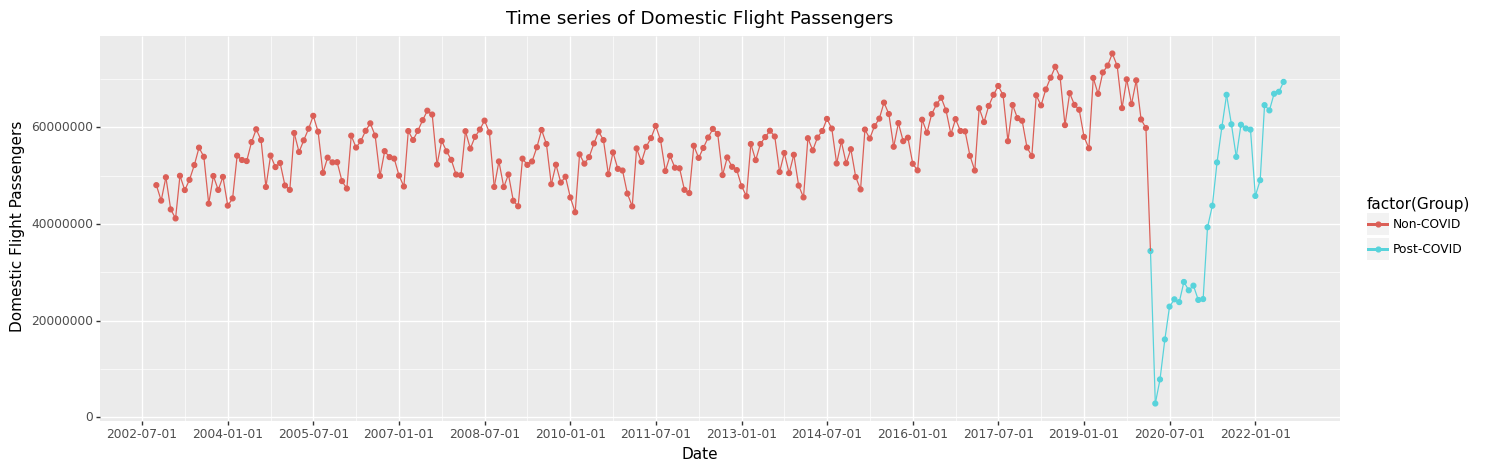

<ggplot: (8789822026449)>

In [ ]:
# Plot domestic data
(
    ggplot(df,aes('Date','DOMESTIC', group = 1, color='factor(Group)')) + geom_point() + geom_line() + ggtitle("Time series of Domestic Flight Passengers") +
  xlab("Date") + ylab("Domestic Flight Passengers") + theme(figure_size=(16, 5)) + scale_x_datetime(breaks=date_breaks('18 months'))
    )

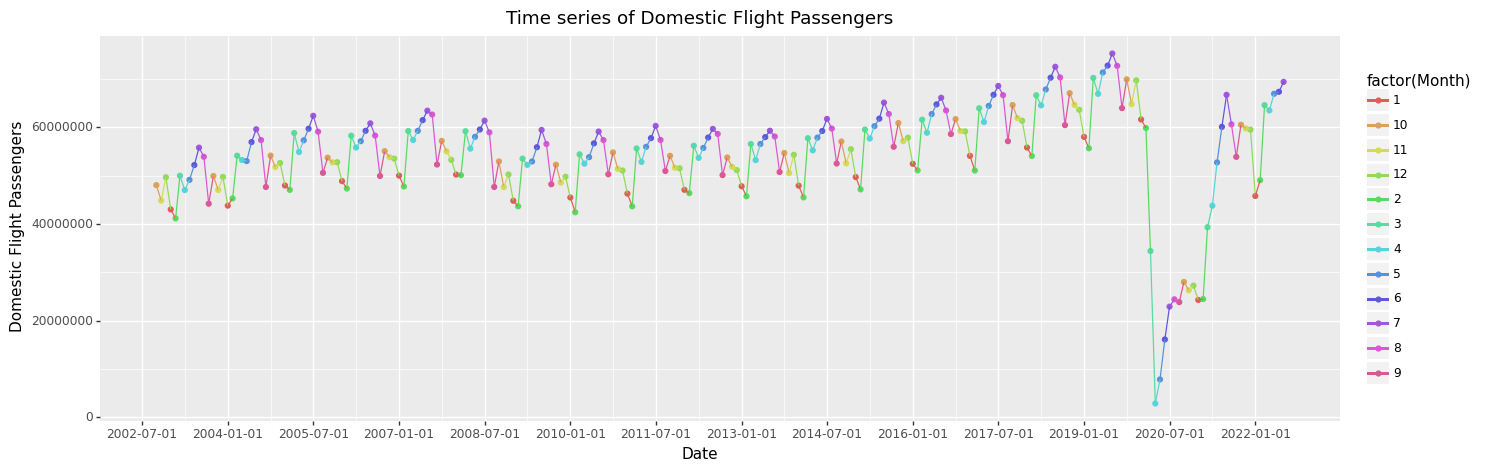

<ggplot: (8789821193721)>

In [ ]:
# Plot domestic data color grouped by month
(
    ggplot(df,aes('Date','DOMESTIC', group = 1, color='factor(Month)')) + geom_point() + geom_line() + ggtitle("Time series of Domestic Flight Passengers") +
  xlab("Date") + ylab("Domestic Flight Passengers") + theme(figure_size=(16, 5)) + scale_x_datetime(breaks=date_breaks('18 months'))
    )

**DATA MODELING**

In [ ]:
# Create 2 columns Trend = 1,2,3,.... and Time = 1,2,3,...
df['Time'] = list(range(1,df.shape[0]+1))
df['Trend'] = list(range(1,df.shape[0]+1))

# Create a column DomesticBefore: create a copy of DOMESTIC and replace passengers during COVID with NA
df['DomesticBefore'] = df['DOMESTIC']
df.loc[df['COV']==1,'DomesticBefore'] = np.nan

df.head()

,Month,DOMESTIC,Date,Group,COV,Time,Trend,DomesticBefore
0,10,48054917,2002-10-01,Non-COVID,0,1,1,48054917.0
1,11,44850246,2002-11-01,Non-COVID,0,2,2,44850246.0
2,12,49684353,2002-12-01,Non-COVID,0,3,3,49684353.0
4,1,43032450,2003-01-01,Non-COVID,0,4,4,43032450.0
5,2,41166780,2003-02-01,Non-COVID,0,5,5,41166780.0


In [ ]:
# M1 = Trend + Seasonal -> DomesticBefore = b0 +b1*Trend + b2...b3 * Seasonal dummies(Month column)
M1 = smf.ols('DomesticBefore ~ Trend + C(Month)',data = df).fit()
print(M1.summary())

                            OLS Regression Results                            
Dep. Variable:         DomesticBefore   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     60.11
Date:                Wed, 19 Oct 2022   Prob (F-statistic):           5.49e-59
Time:                        20:58:36   Log-Likelihood:                -3421.1
No. Observations:                 209   AIC:                             6868.
Df Residuals:                     196   BIC:                             6912.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        4.26e+07   8.52e+05     50.

In [ ]:
# Save Predicted/fitted values (estimate of systematic patterns) in column M1 in df
df['M1'] = M1.fittedvalues

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 29 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 29 rows containing missing values.


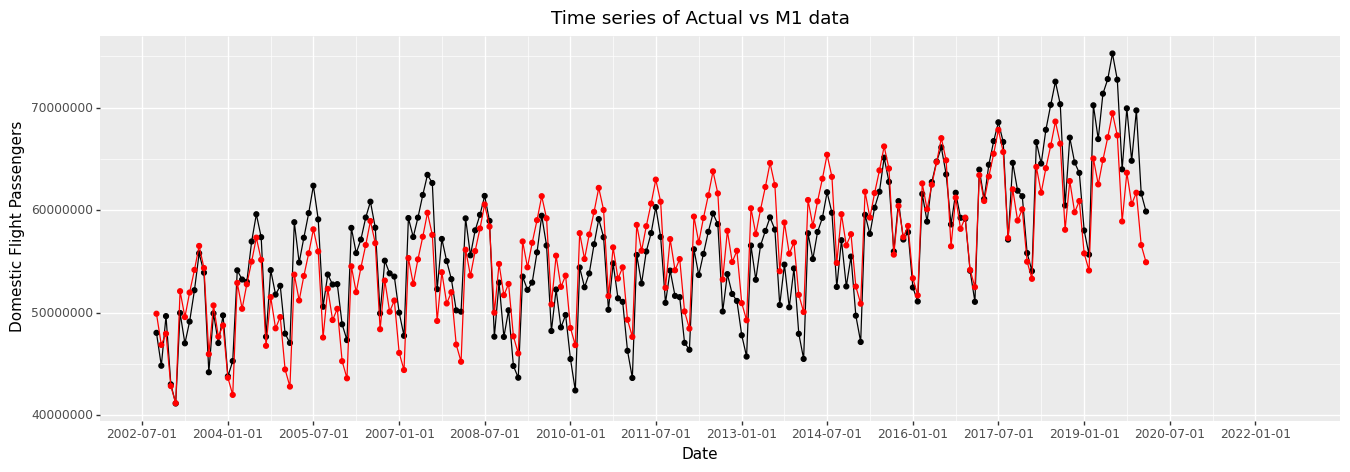

<ggplot: (8789821024153)>

In [ ]:
# Plot data and overlay fitted values
(
    ggplot(df,aes('Date','DomesticBefore', group = 1)) + geom_point() + geom_line() +
 geom_point(aes('Date','M1'), color='red') + geom_line(aes('Date','M1'),color='red') + ggtitle("Time series of Actual vs M1 data") +
  xlab("Date") + ylab("Domestic Flight Passengers") + theme(figure_size=(16, 5)) + scale_x_datetime(breaks=date_breaks('18 months'))
)

In [ ]:
# Store model M1 residuals in column M1residuals in df
df['M1residuals'] = M1.resid

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 29 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 29 rows containing missing values.


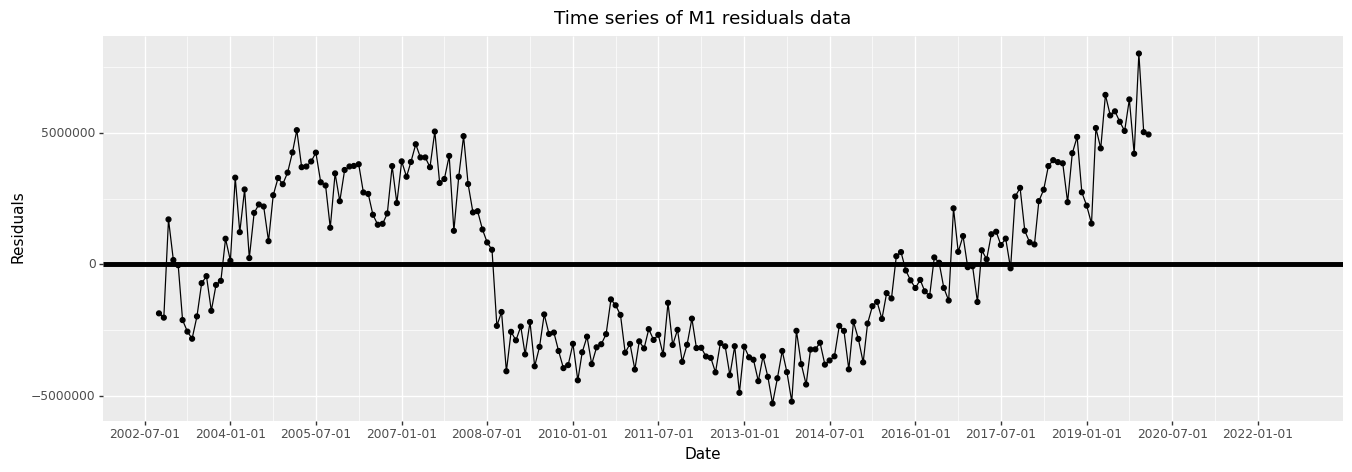

<ggplot: (8789822969665)>

In [ ]:
(
    ggplot(df,aes('Date','M1residuals', group = 1)) + geom_point() + geom_line() + ggtitle("Time series of M1 residuals data") +
  xlab("Date") + ylab("Residuals") + theme(figure_size=(16, 5)) + scale_x_datetime(breaks=date_breaks('18 months')) +
 geom_hline(yintercept=0, size=2)
)

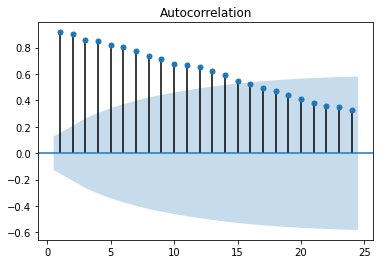

In [ ]:
# Plotting ACF of residuals
plot_acf(df['M1residuals'],missing='drop',zero=False);

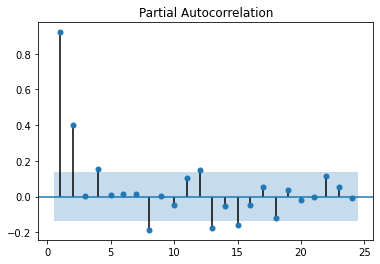

In [ ]:
# Plotting PACF
plot_pacf(df.loc[df['M1residuals'].notna(),'M1residuals'],zero=False);

In [ ]:
# Implementing lags from PAFC into our dataframe
df['DomesticBeforeLag1'] = df['DomesticBefore'].shift(1)
df['DomesticBeforeLag2'] = df['DomesticBefore'].shift(2)
df['DomesticBeforeLag4'] = df['DomesticBefore'].shift(4)
df['DomesticBeforeLag8'] = df['DomesticBefore'].shift(8)
df['DomesticBeforeLag12'] = df['DomesticBefore'].shift(12)
df['DomesticBeforeLag13'] = df['DomesticBefore'].shift(13)
df['DomesticBeforeLag15'] = df['DomesticBefore'].shift(15)

In [ ]:
df.head()

,Month,DOMESTIC,Date,Group,COV,Time,Trend,DomesticBefore,M1,M1residuals,DomesticBeforeLag1,DomesticBeforeLag2,DomesticBeforeLag4,DomesticBeforeLag8,DomesticBeforeLag12,DomesticBeforeLag13,DomesticBeforeLag15
0,10,48054917,2002-10-01,Non-COVID,0,1,1,48054917.0,4.992026e+07,-1.865340e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11,44850246,2002-11-01,Non-COVID,0,2,2,44850246.0,4.687917e+07,-2.028927e+06,48054917.0,NaN,NaN,NaN,NaN,NaN,NaN
2,12,49684353,2002-12-01,Non-COVID,0,3,3,49684353.0,4.797354e+07,1.710816e+06,44850246.0,48054917.0,NaN,NaN,NaN,NaN,NaN
4,1,43032450,2003-01-01,Non-COVID,0,4,4,43032450.0,4.286889e+07,1.635556e+05,49684353.0,44850246.0,NaN,NaN,NaN,NaN,NaN
5,2,41166780,2003-02-01,Non-COVID,0,5,5,41166780.0,4.119829e+07,-3.151492e+04,43032450.0,49684353.0,48054917.0,NaN,NaN,NaN,NaN


In [ ]:
# M2 = Trend + Seasonal + Cyclical component
M2 = smf.ols('DomesticBefore ~ Trend + C(Month) + DomesticBeforeLag1 + DomesticBeforeLag2 + DomesticBeforeLag4 + DomesticBeforeLag8 + DomesticBeforeLag12 + DomesticBeforeLag13 + DomesticBeforeLag15',data = df).fit()
print(M2.summary())

                            OLS Regression Results                            
Dep. Variable:         DomesticBefore   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     419.2
Date:                Wed, 19 Oct 2022   Prob (F-statistic):          1.71e-134
Time:                        20:58:39   Log-Likelihood:                -2946.8
No. Observations:                 194   AIC:                             5934.
Df Residuals:                     174   BIC:                             5999.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            -4.47e+04   1

In [ ]:
# Save M2 data
df['M2'] = M2.fittedvalues
df['M2residuals'] = M2.resid

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 44 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 44 rows containing missing values.


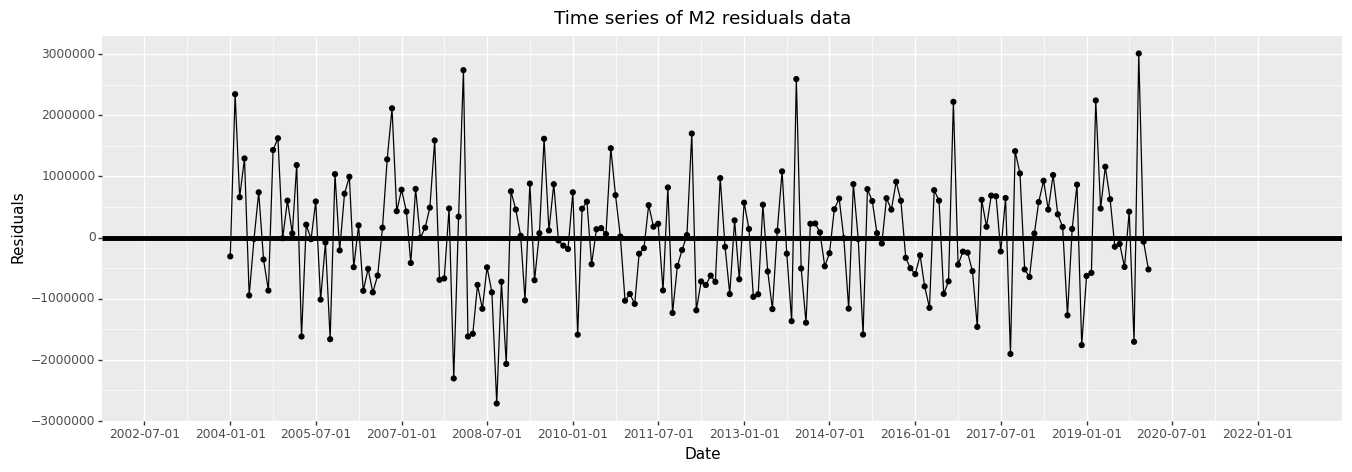

<ggplot: (8789822863601)>

In [ ]:
# Plotting M2 residuals
(
    ggplot(df,aes('Date','M2residuals', group = 1)) + geom_point() + geom_line() + ggtitle("Time series of M2 residuals data") +
  xlab("Date") + ylab("Residuals") + theme(figure_size=(16, 5)) + scale_x_datetime(breaks=date_breaks('18 months')) +
 geom_hline(yintercept=0, size=2)
)

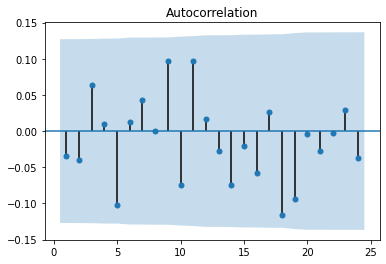

In [ ]:
plot_acf(df['M2residuals'],missing='drop',zero=False);

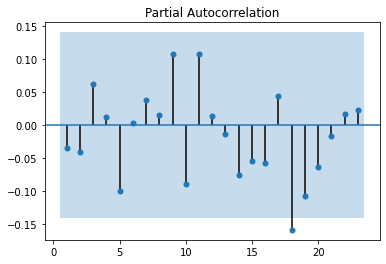

In [ ]:
plot_pacf(df.loc[df['M2residuals'].notna(),'M2residuals'],zero=False);

In [ ]:
# Because we removed total rows in data preparation, integer locations for df
# are different from index labels
# Find correct int. location for start of period
df.iloc[[209]]

,Month,DOMESTIC,Date,Group,COV,Time,Trend,DomesticBefore,M1,M1residuals,DomesticBeforeLag1,DomesticBeforeLag2,DomesticBeforeLag4,DomesticBeforeLag8,DomesticBeforeLag12,DomesticBeforeLag13,DomesticBeforeLag15,M2,M2residuals
227,3,34420555,2020-03-01,Post-COVID,1,210,210,NaN,NaN,NaN,59879630.0,61638893.0,64827417.0,75281916.0,70234129.0,55679481.0,63646582.0,NaN,NaN


In [ ]:
# Find correct int. location for end of period
df.iloc[[237]]

,Month,DOMESTIC,Date,Group,COV,Time,Trend,DomesticBefore,M1,M1residuals,DomesticBeforeLag1,DomesticBeforeLag2,DomesticBeforeLag4,DomesticBeforeLag8,DomesticBeforeLag12,DomesticBeforeLag13,DomesticBeforeLag15,M2,M2residuals
257,7,69414417,2022-07-01,Post-COVID,1,238,238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Now we know the beginning of the COVID period is 209, and the index of the final data row is 237 (and 1 for correct range function execution)
cov_ind = list(range(209, (237+1)))
print(cov_ind)



[209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237]


In [ ]:
# Finding correct column index for DomesticBefore
df.iloc[209, 7]

# DomesticBefore column index = 7
# DomesticBeforeLag1 column index = 7 + 3 = 10
# DomesticBeforeLag2 column index = 10 + 1 = 11
# DomesticBeforeLag4 column index = 10 + 2 = 12
# DomesticBeforeLag8 column index = 10 + 3 = 13
# DomesticBeforeLag12 column index = 10 + 4 = 14
# DomesticBeforeLag13 column index = 10 + 5 = 15
# DomesticBeforeLag15 column index = 10 + 6 = 16
# M2 column index = 16 + 1 = 17

nan

In [ ]:
# Testing prediction with first COVID data
df.iloc[209, 10] = df.iloc[209-1, 7]
df.iloc[209, 11] = df.iloc[209-2, 7]
df.iloc[209, 12] = df.iloc[209-4, 7]
df.iloc[209, 13] = df.iloc[209-8, 7]
df.iloc[209, 14] = df.iloc[209-12, 7]
df.iloc[209, 15] = df.iloc[209-13, 7]
df.iloc[209, 16] = df.iloc[209-15, 7]

df.iloc[209, 7] = M2.predict(df.iloc[[209]]).values
df.iloc[209, 17] = M2.predict(df.iloc[[209]]).values

In [ ]:
df.iloc[209, 13]

75281916.0

In [ ]:
df.iloc[209:]

,Month,DOMESTIC,Date,Group,COV,Time,Trend,DomesticBefore,M1,M1residuals,DomesticBeforeLag1,DomesticBeforeLag2,DomesticBeforeLag4,DomesticBeforeLag8,DomesticBeforeLag12,DomesticBeforeLag13,DomesticBeforeLag15,M2,M2residuals
227,3,34420555,2020-03-01,Post-COVID,1,210,210,7.153409e+07,NaN,NaN,59879630.0,61638893.0,64827417.0,75281916.0,70234129.0,55679481.0,63646582.0,7.153409e+07,NaN
228,4,2879712,2020-04-01,Post-COVID,1,211,211,NaN,NaN,NaN,NaN,59879630.0,69737438.0,72729199.0,66938654.0,70234129.0,58034262.0,NaN,NaN
229,5,7861491,2020-05-01,Post-COVID,1,212,212,NaN,NaN,NaN,NaN,NaN,61638893.0,63991365.0,71364145.0,66938654.0,55679481.0,NaN,NaN
230,6,16132885,2020-06-01,Post-COVID,1,213,213,NaN,NaN,NaN,NaN,NaN,59879630.0,69936836.0,72790418.0,71364145.0,70234129.0,NaN,NaN
231,7,22922158,2020-07-01,Post-COVID,1,214,214,NaN,NaN,NaN,NaN,NaN,NaN,64827417.0,75281916.0,72790418.0,66938654.0,NaN,NaN
232,8,24431822,2020-08-01,Post-COVID,1,215,215,NaN,NaN,NaN,NaN,NaN,NaN,69737438.0,72729199.0,75281916.0,71364145.0,NaN,NaN
233,9,23854772,2020-09-01,Post-COVID,1,216,216,NaN,NaN,NaN,NaN,NaN,NaN,61638893.0,63991365.0,72729199.0,72790418.0,NaN,NaN
234,10,28027209,2020-10-01,Post-COVID,1,217,217,NaN,NaN,NaN,NaN,NaN,NaN,59879630.0,69936836.0,63991365.0,75281916.0,NaN,NaN
235,11,26294514,2020-11-01,Post-COVID,1,218,218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64827417.0,69936836.0,72729199.0,NaN,NaN
236,12,27264199,2020-12-01,Post-COVID,1,219,219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69737438.0,64827417.0,63991365.0,NaN,NaN


In [ ]:
df.iloc[209, 7]

71534094.01279892

In [ ]:
# Use loop to automate data prediction
for i in cov_ind:
  df.iloc[i, 10] = df.iloc[i-1, 7]
  df.iloc[i, 11] = df.iloc[i-2, 7]
  df.iloc[i, 12] = df.iloc[i-4, 7]
  df.iloc[i, 13] = df.iloc[i-8, 7]
  df.iloc[i, 14] = df.iloc[i-12, 7]
  df.iloc[i, 15] = df.iloc[i-13, 7]
  df.iloc[i, 16] = df.iloc[i-15, 7]

  df.iloc[i, 7] = M2.predict(df.iloc[[i]]).values
  df.iloc[i, 17] = M2.predict(df.iloc[[i]]).values

In [ ]:
df.iloc[209:]

,Month,DOMESTIC,Date,Group,COV,Time,Trend,DomesticBefore,M1,M1residuals,DomesticBeforeLag1,DomesticBeforeLag2,DomesticBeforeLag4,DomesticBeforeLag8,DomesticBeforeLag12,DomesticBeforeLag13,DomesticBeforeLag15,M2,M2residuals
227,3,34420555,2020-03-01,Post-COVID,1,210,210,7.153409e+07,NaN,NaN,5.987963e+07,6.163889e+07,6.482742e+07,7.528192e+07,7.023413e+07,5.567948e+07,6.364658e+07,7.153409e+07,NaN
228,4,2879712,2020-04-01,Post-COVID,1,211,211,6.986569e+07,NaN,NaN,7.153409e+07,5.987963e+07,6.973744e+07,7.272920e+07,6.693865e+07,7.023413e+07,5.803426e+07,6.986569e+07,NaN
229,5,7861491,2020-05-01,Post-COVID,1,212,212,7.299048e+07,NaN,NaN,6.986569e+07,7.153409e+07,6.163889e+07,6.399136e+07,7.136414e+07,6.693865e+07,5.567948e+07,7.299048e+07,NaN
230,6,16132885,2020-06-01,Post-COVID,1,213,213,7.444087e+07,NaN,NaN,7.299048e+07,6.986569e+07,5.987963e+07,6.993684e+07,7.279042e+07,7.136414e+07,7.023413e+07,7.444087e+07,NaN
231,7,22922158,2020-07-01,Post-COVID,1,214,214,7.730892e+07,NaN,NaN,7.444087e+07,7.299048e+07,7.153409e+07,6.482742e+07,7.528192e+07,7.279042e+07,6.693865e+07,7.730892e+07,NaN
232,8,24431822,2020-08-01,Post-COVID,1,215,215,7.408987e+07,NaN,NaN,7.730892e+07,7.444087e+07,6.986569e+07,6.973744e+07,7.272920e+07,7.528192e+07,7.136414e+07,7.408987e+07,NaN
233,9,23854772,2020-09-01,Post-COVID,1,216,216,6.624557e+07,NaN,NaN,7.408987e+07,7.730892e+07,7.299048e+07,6.163889e+07,6.399136e+07,7.272920e+07,7.279042e+07,6.624557e+07,NaN
234,10,28027209,2020-10-01,Post-COVID,1,217,217,7.101880e+07,NaN,NaN,6.624557e+07,7.408987e+07,7.444087e+07,5.987963e+07,6.993684e+07,6.399136e+07,7.528192e+07,7.101880e+07,NaN
235,11,26294514,2020-11-01,Post-COVID,1,218,218,6.761074e+07,NaN,NaN,7.101880e+07,6.624557e+07,7.730892e+07,7.153409e+07,6.482742e+07,6.993684e+07,7.272920e+07,6.761074e+07,NaN
236,12,27264199,2020-12-01,Post-COVID,1,219,219,6.939484e+07,NaN,NaN,6.761074e+07,7.101880e+07,7.408987e+07,6.986569e+07,6.973744e+07,6.482742e+07,6.399136e+07,6.939484e+07,NaN


In [ ]:
# impact of COVID = actual domestic flights(March 2020 - July 2022) - prediction assuming COVID has not happened(March 2020 - July 2022)
round(df.iloc[209:, 1].sum() - df.iloc[209:, 17].sum())

-813225190

In [ ]:
# Calculating impact in percentage scale
# % impact = (total  predicted demand during covid assuming covid has not happened - total actual 
# demand during covid) / total  predicted demand during covid assuming covid has not happened
print((((df.iloc[209:, 17].sum() - df.iloc[209:, 1].sum()) / df.iloc[209:, 17].sum()))*100)

39.47701861111281


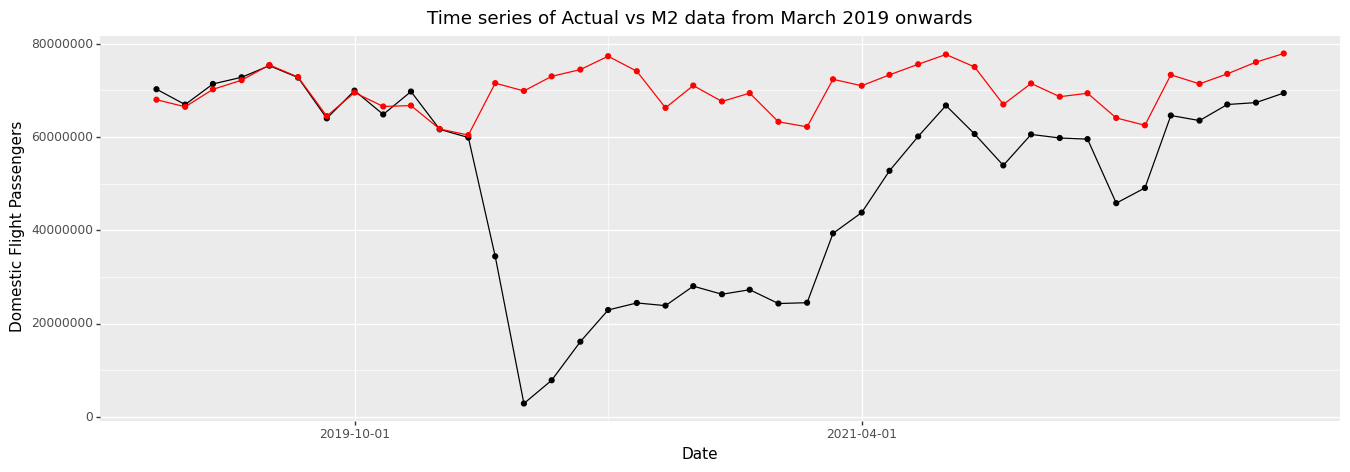

<ggplot: (8789822315737)>

In [ ]:
# Plotting actual COVID demand and predicted demand if COVID hadn't happened
# In order to assess if and/or when industry has recovered

(
    ggplot(df.loc[df['Time']>197],aes('Date','DOMESTIC', group = 1)) + geom_point() + geom_line() +
 geom_point(aes('Date','M2'), color='red') + geom_line(aes('Date','M2'),color='red') + ggtitle("Time series of Actual vs M2 data from March 2019 onwards") +
  xlab("Date") + ylab("Domestic Flight Passengers") + theme(figure_size=(16, 5)) + scale_x_datetime(breaks=date_breaks('18 months'))
)

In [ ]:
# Evaluating RMSE for M2
# before COVID = model's performance on the data set that was used to build a model (training set)
((df.iloc[:208, 1] - df.iloc[:208, 17])**2).mean()**0.5

957927.547313605

In [ ]:
# RMSE for COVID period = data set that was not used to build a model (testing set)
((df.iloc[209:, 1] - df.iloc[209:, 17])**2).mean()**0.5

33793605.84315208

In [ ]:
# Now calculate MAPE for both training and testing sets
# MAPE for training set, MAPE = mean absolute percentage error
round(abs((df.iloc[:208, 1] - df.iloc[:208, 17])/df.iloc[:208, 1]).mean()*100,2)

1.35

In [ ]:
# MAPE on testing set
round(abs((df.iloc[209:, 1] - df.iloc[209:, 17])/df.iloc[209:, 1]).mean()*100,2)

188.75

In [ ]:
# create a function that calculate RMSE and another function that calculates MAPE
def rmse(actual,predicted):
    return round(((actual - predicted)**2).mean()**0.5,2)

def mape(actual,predicted):
    return round(abs((actual - predicted)/actual).mean()*100,2)

In [ ]:
rmse(actual = df.iloc[:208, 1], predicted = df.iloc[:208, 17])

957927.55

In [ ]:
mape(actual = df.iloc[:208, 1], predicted = df.iloc[:208, 17])

1.35

In [ ]:
# Creating empty dataframe to show RMSE and MAPE for different scenarios
pd.DataFrame(columns=['RMSE','MAPE(%)'],index=['Training set','Testing set'])

,RMSE,MAPE(%)
Training set,NaN,NaN
Testing set,NaN,NaN


In [ ]:
# create a function that calculates RMSE and MAPE for training and testing sets given the number 
# of observations in the testing set (h=forecast horizon = the number of observations in the testing set)
# h=0 means there is no testing set
def accuracy(actual,predicted,h=0):
    n_train = len(actual) - h
    accuracy_metrics = pd.DataFrame(columns=['RMSE','MAPE(%)'],index=['Training set','Testing set'])
    accuracy_metrics.loc['Training set','RMSE'] = rmse(actual[:n_train],predicted[:n_train])
    accuracy_metrics.loc['Training set','MAPE(%)'] = mape(actual[:n_train],predicted[:n_train])
    if (h>0):
        accuracy_metrics.loc['Testing set','RMSE'] = rmse(actual[n_train:],predicted[n_train:])
        accuracy_metrics.loc['Testing set','MAPE(%)'] = mape(actual[n_train:],predicted[n_train:])
    return accuracy_metrics

In [ ]:
# Getting length of df
len(df["DOMESTIC"])

238

In [ ]:
# Testing we have correct value for h
print(238 - 29)
df["DOMESTIC"][209:]

209


227    34420555
228     2879712
229     7861491
230    16132885
231    22922158
232    24431822
233    23854772
234    28027209
235    26294514
236    27264199
238    24305908
239    24483505
240    39343495
241    43798946
242    52752164
243    60110694
244    66741175
245    60632081
246    53903524
247    60548494
248    59779348
249    59535445
251    45814651
252    49076378
253    64604568
254    63514551
255    66957127
256    67365493
257    69414417
Name: DOMESTIC, dtype: int64

In [ ]:
accuracy(actual = df['DOMESTIC'], predicted = df['M2'],h=29)

,RMSE,MAPE(%)
Training set,956190.93,1.35
Testing set,33793605.84,188.75


In [ ]:
def accuracy(actual,predicted,h=0):
    n_train = len(actual) - h
    
    # introduce additional n_test variable to ensure testing sets are correctly captured
    n_test = n_train + 12

    accuracy_metrics = pd.DataFrame(columns=['RMSE','MAPE(%)'],index=['Training set','Testing set'])
    accuracy_metrics.loc['Training set','RMSE'] = rmse(actual[:n_train],predicted[:n_train])
    accuracy_metrics.loc['Training set','MAPE(%)'] = mape(actual[:n_train],predicted[:n_train])
    
    # use n_test variable to ensure correct data is used
    if (h>0):
        accuracy_metrics.loc['Testing set','RMSE'] = rmse(actual[n_train:n_test],predicted[n_train:n_test])
        accuracy_metrics.loc['Testing set','MAPE(%)'] = mape(actual[n_train:n_test],predicted[n_train:n_test])
    return accuracy_metrics

In [ ]:
# Obtaining correct h value for Scenario 1
df.iloc[207]
print(238 - 207)

31


In [ ]:
# Scenario 1
accuracy(actual = df['DOMESTIC'], predicted = df['M2'],h=31)

,RMSE,MAPE(%)
Training set,960406.56,1.36
Testing set,46598943.88,392.34


In [ ]:
# Obtaining correct h value for Scenario 2
df.iloc[195]
print(238 - 195)

43


In [ ]:
# Scenario 2
accuracy(actual = df['DOMESTIC'], predicted = df['M2'],h=43)

,RMSE,MAPE(%)
Training set,933743.93,1.35
Testing set,1296119.63,1.43


In [ ]:
# Obtaining correct h value for Scenario 3
df.iloc[183]
print(238 - 183)

55


In [ ]:
# Scenario 3
accuracy(actual = df['DOMESTIC'], predicted = df['M2'],h=55)

,RMSE,MAPE(%)
Training set,939826.89,1.37
Testing set,843991.51,1.08


**MODEL DEPLOYMENT**

In [ ]:
# Creating Exponential Smoothing model
M3 = ExponentialSmoothing(df['DOMESTIC'],trend = 'add',seasonal='mul',seasonal_periods=12).fit()
print(M3.summary())

                        ExponentialSmoothing Model Results                        
Dep. Variable:                 DOMESTIC   No. Observations:                    238
Model:             ExponentialSmoothing   SSE                 3755798774346250.000
Optimized:                         True   AIC                             7264.774
Trend:                         Additive   BIC                             7320.330
Seasonal:                Multiplicative   AICC                            7267.897
Seasonal Periods:                    12   Date:                   Wed, 19 Oct 2022
Box-Cox:                          False   Time:                           20:58:42
Box-Cox Coeff.:                    None                                           
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9596429                alpha                 True
smoothi

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.


In [ ]:
# Using M3 to forecast
M3.forecast(12)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


238    6.718986e+07
239    5.740177e+07
240    6.147535e+07
241    5.740870e+07
242    6.048615e+07
243    5.503336e+07
244    5.349950e+07
245    6.478457e+07
246    5.976474e+07
247    6.581914e+07
248    6.957253e+07
249    7.262845e+07
dtype: float64

In [ ]:
# Use last 2 years of data as testing set for model
# training set = all data - last two years
# testing set = last 2 years of data

df["M3"] = np.nan
len(df)

238

In [ ]:
df.iloc[237]

# Train model using 237 - 24 (months) = 213
# Train model using 237 - 12 (months) = 225
M3 = ExponentialSmoothing(df.iloc[:225, 1],trend = 'add',seasonal='mul',seasonal_periods=12).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.


In [ ]:
df.iloc[:225, 19] = M3.fittedvalues
df.iloc[226:, 19] = M3.forecast(12)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


In [ ]:
df['Prediction'] = 'Fitted values'
df.iloc[226:, 20] = 'Forecast'

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


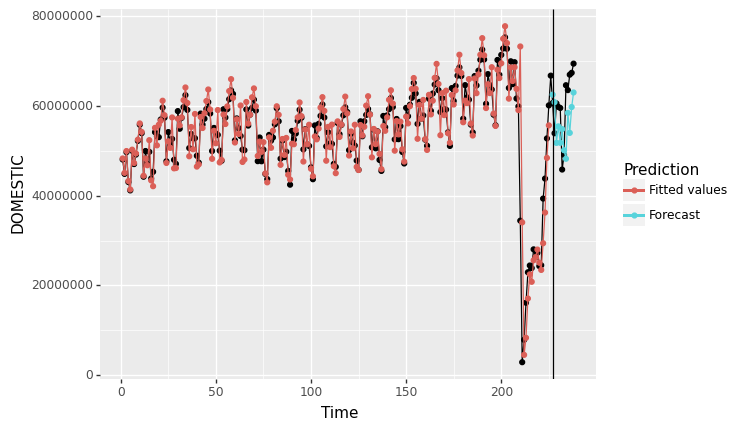

<ggplot: (8789822385001)>

In [ ]:
# Create a a graph of data and overlay fitted values & future forecats. 
(
    ggplot(df,aes('Time','DOMESTIC')) + geom_point() + geom_line()+
 geom_point(aes('Time','M3',color='Prediction')) + geom_line(aes('Time','M3',color='Prediction')) +
 geom_vline(xintercept = 227)
)

In [ ]:
# Build a model using the entire data set, predict data for the next 12 months
M4 = ExponentialSmoothing(df['DOMESTIC'],trend = 'add',seasonal='mul',seasonal_periods=12).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.


In [ ]:
df['M4'] = M4.fittedvalues

In [ ]:
# Create a new data frame to store future forecast
fc_list = list(range(238,238+12))
dfFuture = pd.DataFrame({'Time':fc_list,
                         'FutureForecast':M4.forecast(12)})

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


In [ ]:
dfFuture.head()

,Time,FutureForecast
238,238,6.718986e+07
239,239,5.740177e+07
240,240,6.147535e+07
241,241,5.740870e+07
242,242,6.048615e+07


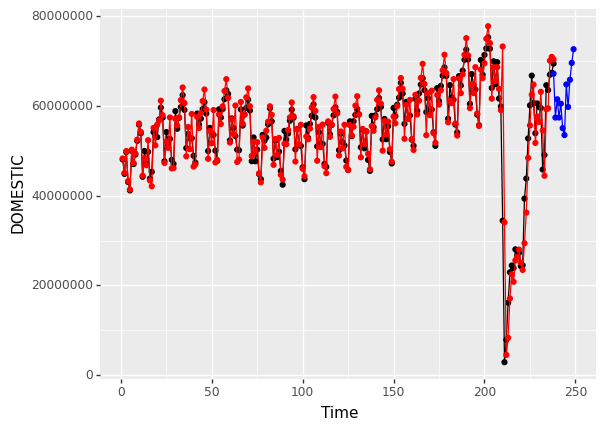

<ggplot: (8789822483865)>

In [ ]:
# Create a a graph of data and overlay fitted values & future forecats. 
(
    ggplot(df,aes('Time','DOMESTIC')) + geom_point() + geom_line()+   # data
 geom_point(aes('Time','M4'),color='red') + geom_line(aes('Time','M4'),color='red') +        # fitted/predicted values
 geom_point(dfFuture,aes('Time','FutureForecast'),color='blue') + geom_line(dfFuture, aes('Time','FutureForecast'),color='blue') 
)

In [ ]:
# Create and plot confidence and prediction intervals
# Find RMSE to use in confidence intervals
RMSE = (M4.sse / len(df))**0.5
RMSE

3972488.781494781

In [ ]:
# Setting bounds for intervals
df['LowerBound'] = df['M4'] - 2*RMSE
df['UpperBound'] = df['M4'] + 2*RMSE
dfFuture['LowerBound'] = dfFuture['FutureForecast'] - 2*RMSE
dfFuture['UpperBound'] = dfFuture['FutureForecast'] + 2*RMSE

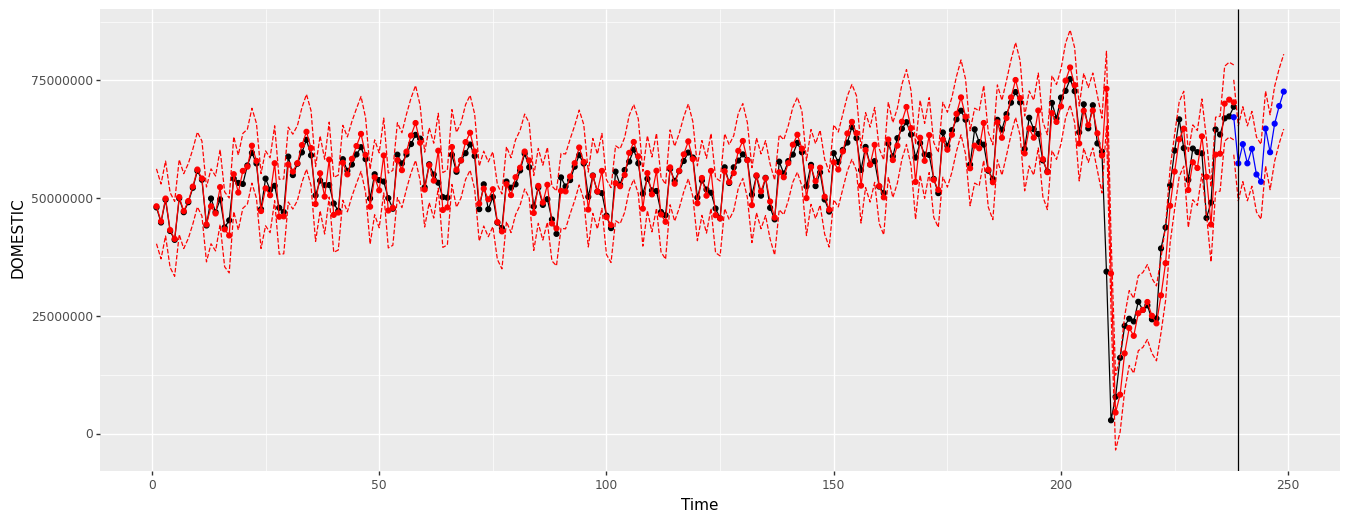

<ggplot: (8789824628457)>

In [ ]:
# Create graph and overlay fitted values, future forecast and conf/pred intervals
CI = 'red'
style='dashed'
(
    ggplot(df,aes('Time','DOMESTIC')) + geom_point() + geom_line() +   # data
 geom_point(aes('Time','M4'),color='red') + geom_line(aes('Time','M4'),color='red') +        # fitted/predicted values
 geom_point(dfFuture,aes('Time','FutureForecast'),color='blue') +  
 geom_line(dfFuture, aes('Time','FutureForecast'),color='blue') + geom_line(aes('Time','LowerBound'),color=CI, linetype=style) + 
 geom_line(aes('Time','UpperBound'),color=CI, linetype=style) + geom_line(dfFuture,aes('Time','LowerBound'),color=CI, linetype=style) + 
 geom_line(dfFuture,aes('Time','UpperBound'),color=CI, linetype=style) + 
 geom_vline(xintercept = len(df)+1) +  theme(figure_size=(16,6))
)

**MODEL EVALUATION**

In [ ]:
# Building functions for RMSE and MAPE calculations:
def rmse(actual,predicted):
    return round(((actual - predicted)**2).mean()**0.5,2)

def mape(actual,predicted):
    return round(abs((actual - predicted)/actual).mean()*100,2)

In [ ]:
# Building function to create table and enter RMSE and MAPE values:
def accuracy(actual,predicted,h=0):
    n_train = len(actual) - h
    accuracy_metrics = pd.DataFrame(columns=['RMSE','MAPE(%)'],index=['Training set','Testing set'])
    accuracy_metrics.loc['Training set','RMSE'] = rmse(actual[:n_train],predicted[:n_train])
    accuracy_metrics.loc['Training set','MAPE(%)'] = mape(actual[:n_train],predicted[:n_train])
    if (h>0):
        accuracy_metrics.loc['Testing set','RMSE'] = rmse(actual[n_train:],predicted[n_train:])
        accuracy_metrics.loc['Testing set','MAPE(%)'] = mape(actual[n_train:],predicted[n_train:])
    return accuracy_metrics

In [ ]:
accuracy(actual = df['DOMESTIC'], predicted = df['M3'],h=12)

,RMSE,MAPE(%)
Training set,3954058.52,8.59
Testing set,8425077.05,12.15


In [ ]:
accuracy(actual = df['DOMESTIC'], predicted = df['M4'],h=12)

,RMSE,MAPE(%)
Training set,3955259.83,8.58
Testing set,4284046.22,6.81


# **CASE 2: ADIDAS AND NIKE**

In [ ]:
# Importing Adidas data
url1 = 'https://raw.githubusercontent.com/carlosfalco/datapacks21-22/main/AdidasNew.csv'
raw1 = pd.read_csv(url1)

# Importing Nike data
url2 = 'https://raw.githubusercontent.com/carlosfalco/datapacks21-22/main/NikeNew.csv'
raw2 = pd.read_csv(url2)

In [ ]:
# Creating function to prepare both data sets
def dataclean(data):

  # We are only interested in Gross Profit, so we use iloc to capture that row
  df = data.iloc[[10]]

  # Transpose data and drop Nans
  df = df.T.dropna()

  # Creating copy of df to continue cleaning data
  df2 = df.copy()

  df.reset_index(drop=True, inplace=True)

  # Putting dataframe indexes in list
  ind_list = list(df2.index)

  # Creating empty list for YQ values
  yq_list = []
  q_list = []

  # Looping through index list removing spaces and appending to new lists
  for n in range(len(ind_list)):
    value = ind_list[n]
    quarter = value[5:]
    q_list.append(quarter)
    value = value.replace(" ", "")
    yq_list.append(value)

  # Changing first value to new column name
  yq_list[0] = "YQ"

  # Adding YQ and Q lists to dataframe
  df["YQ"] = yq_list
  df["FQ"] = q_list

  # Changing header of dataframe
  new_header = df.iloc[0] 
  df = df[1:]
  df.columns = new_header

  # Creating integer list for quarters and adding to dataframe
  quarter_list = list(range(len(df["YQ"])))
  df["Quarter"] = quarter_list

  # Renaming Gross Profit and FQ column
  df = df.rename(columns={df.columns[0]: "GrossProfit"})
  df = df.rename(columns={df.columns[2]: "FQ"})

  # Removing commas and turing GP column into integers
  df = df.replace(',','', regex=True)
  df['GrossProfit'] = df['GrossProfit'].astype('int')

  return df

In [ ]:
# Inputting raw data for Nike and Adidas for preparation
df_a = dataclean(raw1)
df_n = dataclean(raw2)

In [ ]:
# Adidas data
df_a.head()

,GrossProfit,YQ,FQ,Quarter
1,664763,1999FQ1,FQ1,0
2,583145,1999FQ2,FQ2,1
3,713351,1999FQ3,FQ3,2
4,545443,1999FQ4,FQ4,3
5,628334,2000FQ1,FQ1,4


In [ ]:
# Nike data
df_n.head()

,GrossProfit,YQ,FQ,Quarter
1,374866,1994FQ1,FQ1,0
2,309661,1994FQ2,FQ2,1
3,334779,1994FQ3,FQ3,2
4,395234,1994FQ4,FQ4,3
5,469908,1995FQ1,FQ1,4


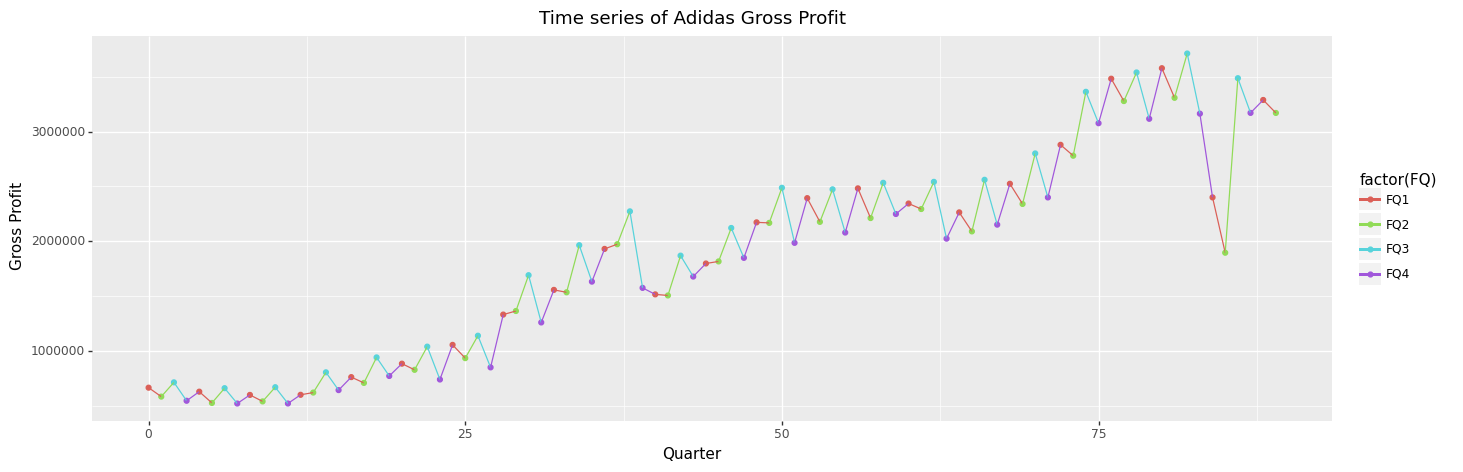

<ggplot: (8789822439769)>

In [ ]:
# Graphing Adidas GP
(
    ggplot(df_a,aes('Quarter','GrossProfit', group = 1, color="factor(FQ)")) + geom_point() + geom_line() + ggtitle("Time series of Adidas Gross Profit") +
  xlab("Quarter") + ylab("Gross Profit") + theme(figure_size=(16, 5))
    )

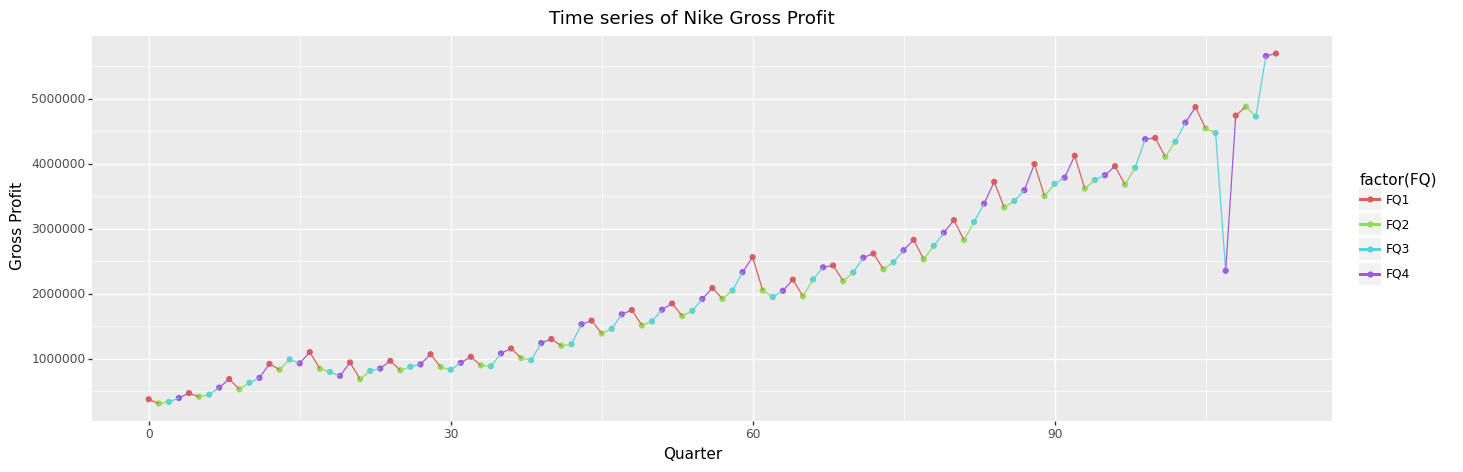

<ggplot: (8789822422809)>

In [ ]:
# Graphing Nike GP
(
    ggplot(df_n,aes('Quarter','GrossProfit', group = 1, color="factor(FQ)")) + geom_point() + geom_line() + ggtitle("Time series of Nike Gross Profit") +
  xlab("Quarter") + ylab("Gross Profit") + theme(figure_size=(16, 5))
    )

In [ ]:
# Assigning groups to both datasets
# Adidas
df_a['Group'] = "Pre-COVID"
df_a.loc[85:,'Group'] = "Post-COVID"

df_a['COV'] = 0
df_a.loc[85:,'COV'] = 1

# Nike
df_n['Group'] = "Pre-COVID"
df_n.loc[108:,'Group'] = "Post-COVID"

df_n['COV'] = 0
df_n.loc[108:,'COV'] = 1

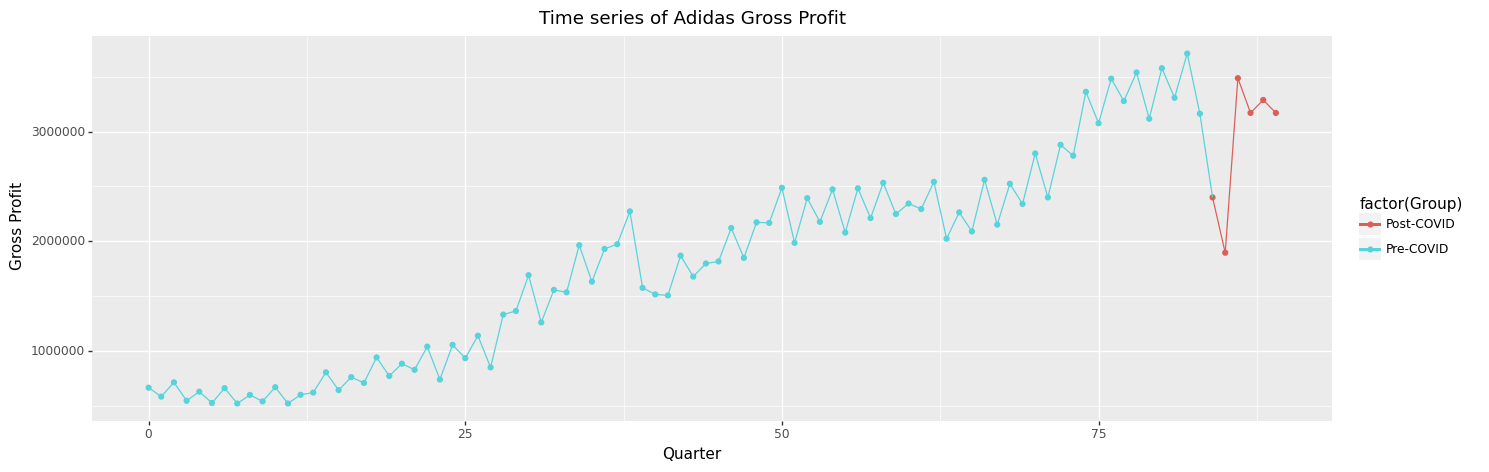

<ggplot: (8789822416813)>

In [ ]:
# Plotting Adidas with COVID group
(
    ggplot(df_a,aes('Quarter','GrossProfit', group = 1, color='factor(Group)')) + geom_point() + geom_line() + ggtitle("Time series of Adidas Gross Profit") +
  xlab("Quarter") + ylab("Gross Profit") + theme(figure_size=(16, 5))
    )

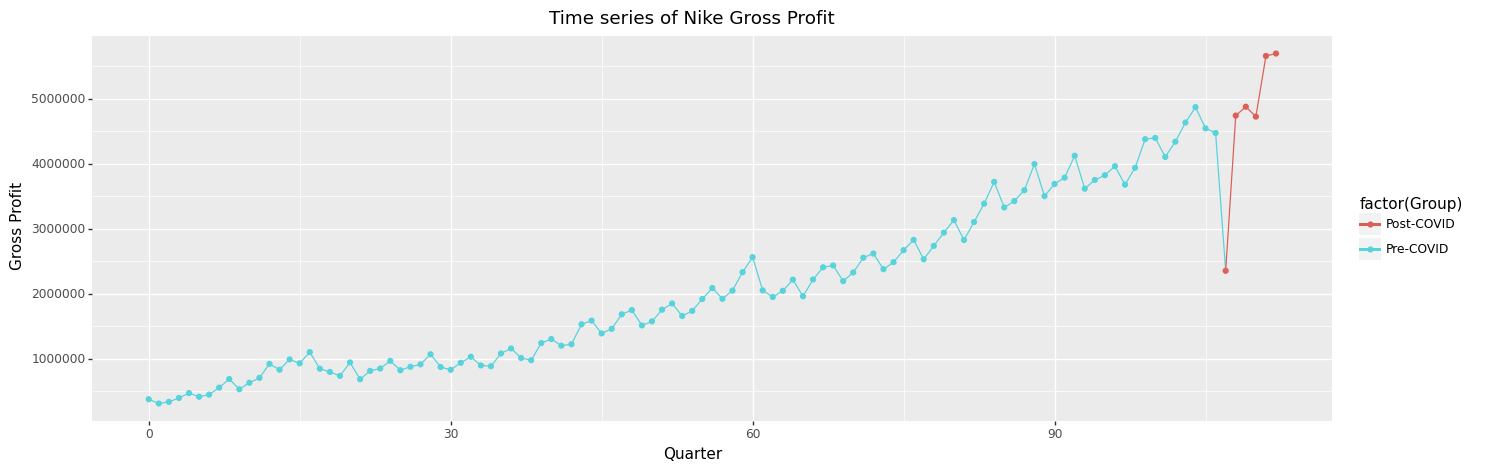

<ggplot: (8789822136785)>

In [ ]:
# Plotting Nike with COVID group
(
    ggplot(df_n,aes('Quarter','GrossProfit', group = 1, color='factor(Group)')) + geom_point() + geom_line() + ggtitle("Time series of Nike Gross Profit") +
  xlab("Quarter") + ylab("Gross Profit") + theme(figure_size=(16, 5))
    )

In [ ]:
df_a.loc[85]

0
GrossProfit       2400652
YQ                2020FQ1
FQ                    FQ1
Quarter                84
Group          Post-COVID
COV                     1
Name: 85, dtype: object

In [ ]:
df_n.loc[108]

0
GrossProfit       2353000
YQ                2020FQ4
FQ                    FQ4
Quarter               107
Group          Post-COVID
COV                     1
Name: 108, dtype: object

In [ ]:
# Defining function to prepare data for M1 
def m1prep(data):
  # Create Trend Columns
  data['Trend'] = list(range(1,data.shape[0]+1))

  # Create a column GPBefore: create a copy of GrossProfit and replace values during COVID with NA
  data['GPBefore'] = data['GrossProfit']
  data.loc[data['COV']==1,'GPBefore'] = np.nan

  return data

In [ ]:
# Applying function
df_a = m1prep(df_a)
df_n = m1prep(df_n)

In [ ]:
df_a.tail()

,GrossProfit,YQ,FQ,Quarter,Group,COV,Trend,GPBefore
86,1895796,2020FQ2,FQ2,85,Post-COVID,1,86,NaN
87,3487898,2020FQ3,FQ3,86,Post-COVID,1,87,NaN
88,3171484,2020FQ4,FQ4,87,Post-COVID,1,88,NaN
89,3289383,2021FQ1,FQ1,88,Post-COVID,1,89,NaN
90,3171027,2021FQ2,FQ2,89,Post-COVID,1,90,NaN


In [ ]:
# M1 = Trend + Seasonal -> DomesticBefore = b0 +b1*Trend + b2...b3 * Seasonal dummies(Month column)
M1a = smf.ols('GPBefore ~ Trend + C(FQ)',data = df_a).fit()
print(M1a.summary())

                            OLS Regression Results                            
Dep. Variable:               GPBefore   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     353.3
Date:                Wed, 19 Oct 2022   Prob (F-statistic):           1.49e-49
Time:                        20:58:48   Log-Likelihood:                -1147.8
No. Observations:                  84   AIC:                             2306.
Df Residuals:                      79   BIC:                             2318.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     3.098e+05   6.14e+04      5.050   

In [ ]:
M1n = smf.ols('GPBefore ~ Trend + C(FQ)',data = df_n).fit()
print(M1n.summary())

                            OLS Regression Results                            
Dep. Variable:               GPBefore   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     443.9
Date:                Wed, 19 Oct 2022   Prob (F-statistic):           1.51e-63
Time:                        20:58:48   Log-Likelihood:                -1498.5
No. Observations:                 107   AIC:                             3007.
Df Residuals:                     102   BIC:                             3020.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     6.505e+04   7.61e+04      0.855   

In [ ]:
# Save M1 data
df_a['M1a'] = M1a.fittedvalues
df_a['M1aResiduals'] = M1a.resid

df_n['M1n'] = M1n.fittedvalues
df_n['M1nResiduals'] = M1n.resid

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 6 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 6 rows containing missing values.


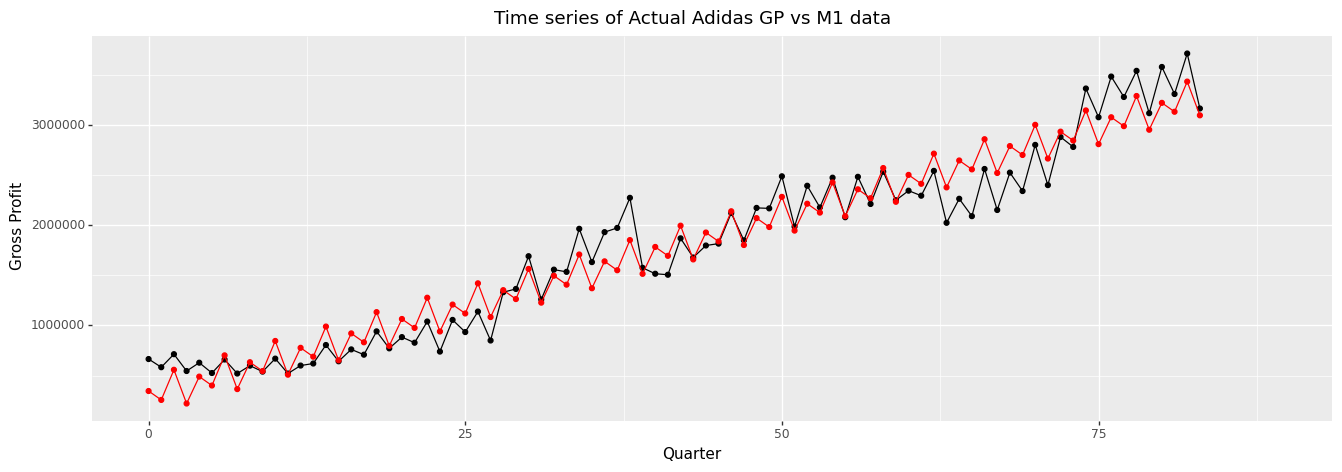

<ggplot: (8789822445477)>

In [ ]:
# Plot data and overlay fitted values
(
    ggplot(df_a,aes('Quarter','GPBefore', group = 1)) + geom_point() + geom_line() +
 geom_point(aes('Quarter','M1a'), color='red') + geom_line(aes('Quarter','M1a'),color='red') + ggtitle("Time series of Actual Adidas GP vs M1 data") +
  xlab("Quarter") + ylab("Gross Profit") + theme(figure_size=(16, 5))
)

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 6 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 6 rows containing missing values.


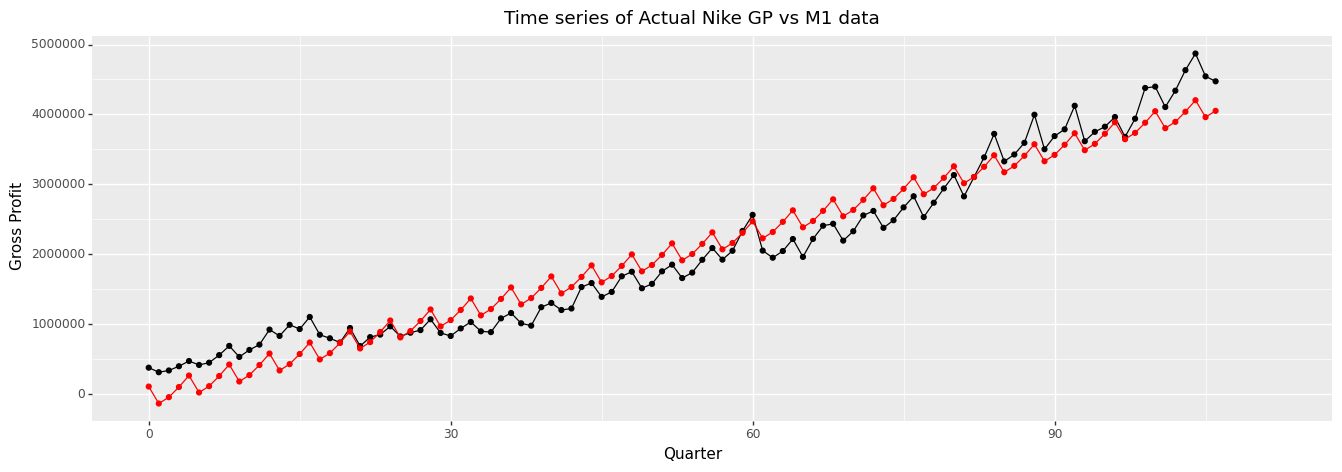

<ggplot: (8789821069153)>

In [ ]:
(
    ggplot(df_n,aes('Quarter','GPBefore', group = 1)) + geom_point() + geom_line() +
 geom_point(aes('Quarter','M1n'), color='red') + geom_line(aes('Quarter','M1n'),color='red') + ggtitle("Time series of Actual Nike GP vs M1 data") +
  xlab("Quarter") + ylab("Gross Profit") + theme(figure_size=(16, 5))
)

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 6 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 6 rows containing missing values.


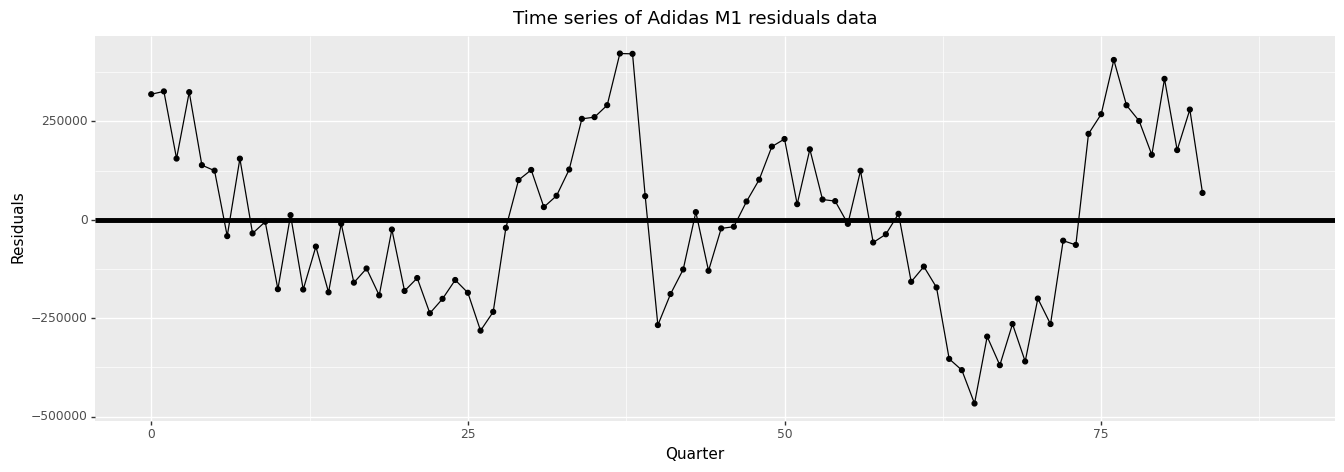

<ggplot: (8789821048797)>

In [ ]:
# Time Series of M1 Residuals
(
    ggplot(df_a,aes('Quarter','M1aResiduals', group = 1)) + geom_point() + geom_line() + ggtitle("Time series of Adidas M1 residuals data") +
  xlab("Quarter") + ylab("Residuals") + theme(figure_size=(16, 5)) +
 geom_hline(yintercept=0, size=2)
)

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 6 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 6 rows containing missing values.


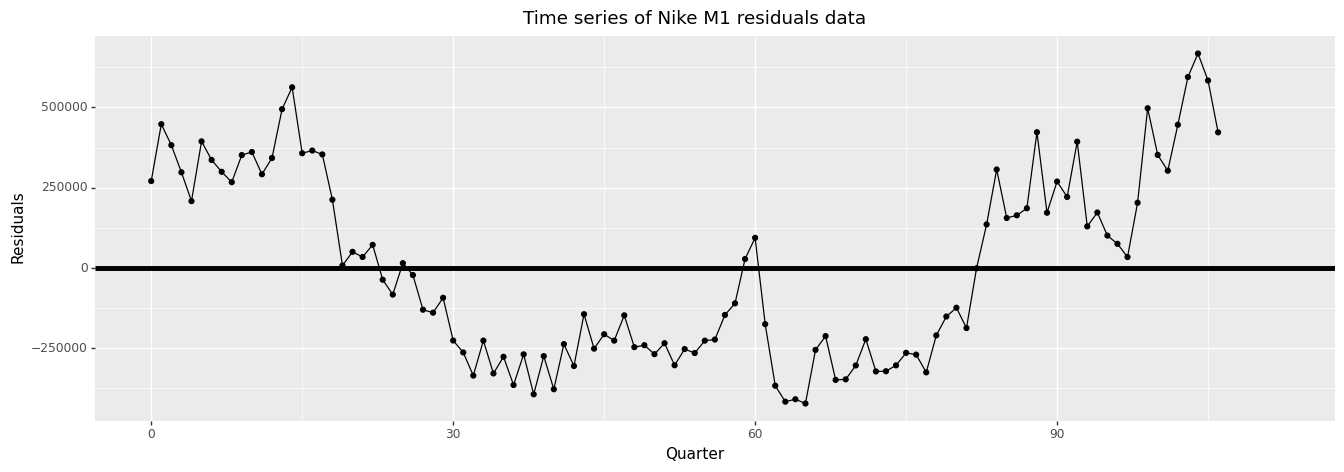

<ggplot: (8789821163217)>

In [ ]:
(
    ggplot(df_n,aes('Quarter','M1nResiduals', group = 1)) + geom_point() + geom_line() + ggtitle("Time series of Nike M1 residuals data") +
  xlab("Quarter") + ylab("Residuals") + theme(figure_size=(16, 5)) +
 geom_hline(yintercept=0, size=2)
)

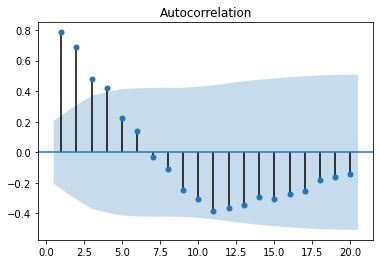

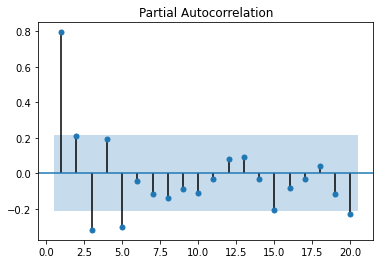

In [ ]:
# Adidas
# Plotting ACF of residuals
plot_acf(df_a['M1aResiduals'],missing='drop',zero=False);

# Plotting PACF
plot_pacf(df_a.loc[df_a['M1aResiduals'].notna(),'M1aResiduals'],zero=False);

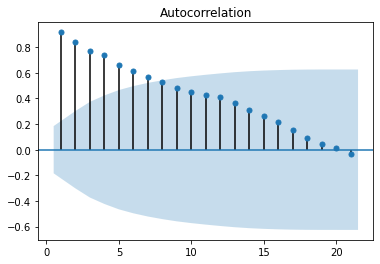

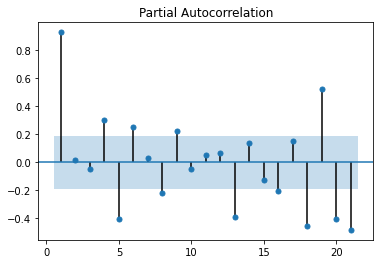

In [ ]:
# Nike
# Plotting ACF of residuals
plot_acf(df_n['M1nResiduals'],missing='drop',zero=False);

# Plotting PACF
plot_pacf(df_n.loc[df_n['M1nResiduals'].notna(),'M1nResiduals'],zero=False);

In [ ]:
# Implementing lags from PAFC into our dataframes

# Adidas
df_a['GPBeforeLag1'] = df_a['GPBefore'].shift(1)
df_a['GPBeforeLag3'] = df_a['GPBefore'].shift(3)
df_a['GPBeforeLag5'] = df_a['GPBefore'].shift(5)
df_a['GPBeforeLag20'] = df_a['GPBefore'].shift(20)

# Nike
df_n['GPBeforeLag1'] = df_n['GPBefore'].shift(1)
df_n['GPBeforeLag4'] = df_n['GPBefore'].shift(4)
df_n['GPBeforeLag5'] = df_n['GPBefore'].shift(5)
df_n['GPBeforeLag6'] = df_n['GPBefore'].shift(6)
df_n['GPBeforeLag8'] = df_n['GPBefore'].shift(8)
df_n['GPBeforeLag9'] = df_n['GPBefore'].shift(9)
df_n['GPBeforeLag13'] = df_n['GPBefore'].shift(13)
df_n['GPBeforeLag16'] = df_n['GPBefore'].shift(16)
df_n['GPBeforeLag18'] = df_n['GPBefore'].shift(18)
df_n['GPBeforeLag19'] = df_n['GPBefore'].shift(19)
df_n['GPBeforeLag20'] = df_n['GPBefore'].shift(20)
df_n['GPBeforeLag21'] = df_n['GPBefore'].shift(21)

In [ ]:
# M2 = Trend + Seasonal + Cyclical component
M2a = smf.ols('GPBefore ~ Trend + C(FQ) + GPBeforeLag1 + GPBeforeLag3 + GPBeforeLag5 + GPBeforeLag20', data = df_a).fit()
print(M2a.summary())

                            OLS Regression Results                            
Dep. Variable:               GPBefore   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     279.6
Date:                Wed, 19 Oct 2022   Prob (F-statistic):           1.13e-41
Time:                        20:58:51   Log-Likelihood:                -836.21
No. Observations:                  64   AIC:                             1690.
Df Residuals:                      55   BIC:                             1710.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2.572e+05   6.66e+04      3.863

In [ ]:
M2n = smf.ols('GPBefore ~ Trend + C(FQ) + GPBeforeLag1 + GPBeforeLag4 + GPBeforeLag5 + GPBeforeLag6 + GPBeforeLag8 + GPBeforeLag9 + GPBeforeLag13 + GPBeforeLag16 + GPBeforeLag18 + GPBeforeLag19 + GPBeforeLag20 + GPBeforeLag21', data = df_n).fit()
print(M2n.summary())

                            OLS Regression Results                            
Dep. Variable:               GPBefore   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     790.8
Date:                Wed, 19 Oct 2022   Prob (F-statistic):           1.62e-71
Time:                        20:58:52   Log-Likelihood:                -1099.5
No. Observations:                  86   AIC:                             2233.
Df Residuals:                      69   BIC:                             2275.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      4.743e+04   6.21e+04      0.763

In [ ]:
# Save M2 data
df_a['M2a'] = M2a.fittedvalues
df_a['M2aResiduals'] = M2a.resid

df_n['M2n'] = M2n.fittedvalues
df_n['M2nResiduals'] = M2n.resid

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 26 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 26 rows containing missing values.


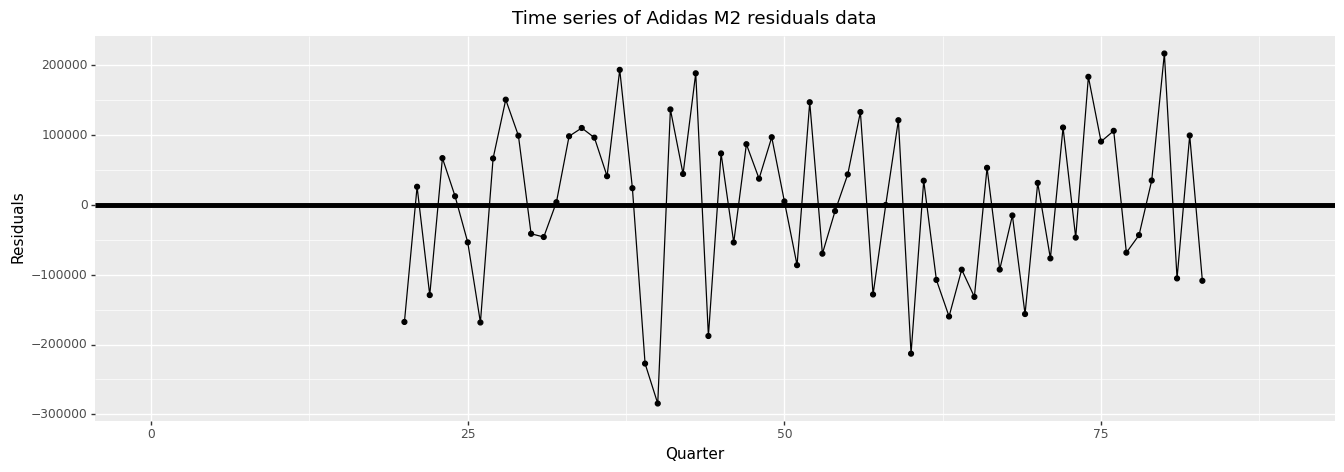

<ggplot: (8789827370329)>

In [ ]:
# Time Series of M1 Residuals
(
    ggplot(df_a,aes('Quarter','M2aResiduals', group = 1)) + geom_point() + geom_line() + ggtitle("Time series of Adidas M2 residuals data") +
  xlab("Quarter") + ylab("Residuals") + theme(figure_size=(16, 5)) +
 geom_hline(yintercept=0, size=2)
)

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 27 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 27 rows containing missing values.


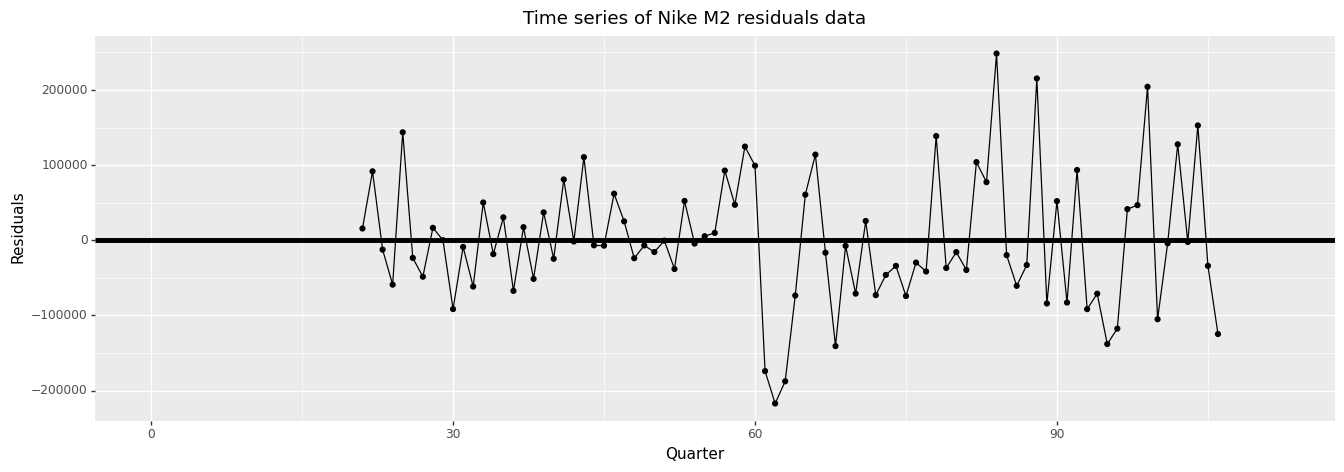

<ggplot: (8789822209533)>

In [ ]:
(
    ggplot(df_n,aes('Quarter','M2nResiduals', group = 1)) + geom_point() + geom_line() + ggtitle("Time series of Nike M2 residuals data") +
  xlab("Quarter") + ylab("Residuals") + theme(figure_size=(16, 5)) +
 geom_hline(yintercept=0, size=2)
)

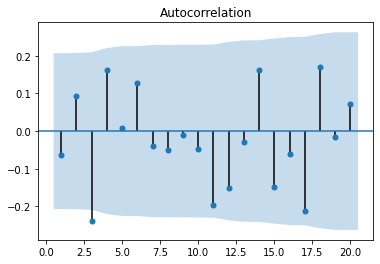

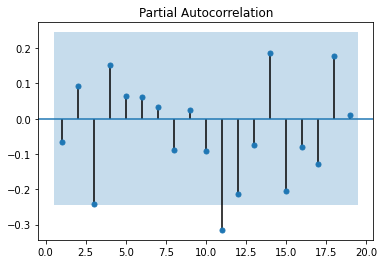

In [ ]:
# Adidas
# Plotting ACF of residuals
plot_acf(df_a['M2aResiduals'],missing='drop',zero=False);

# Plotting PACF
plot_pacf(df_a.loc[df_a['M2aResiduals'].notna(),'M2aResiduals'],zero=False);

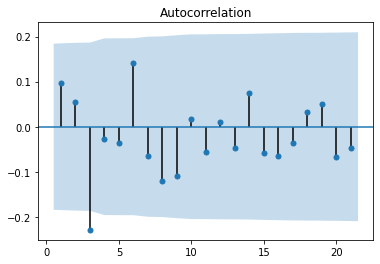

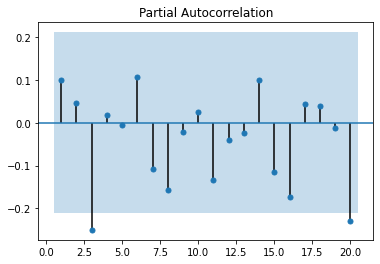

In [ ]:
# Nike
# Plotting ACF of residuals
plot_acf(df_n['M2nResiduals'],missing='drop',zero=False);

# Plotting PACF
plot_pacf(df_n.loc[df_n['M2nResiduals'].notna(),'M2nResiduals'],zero=False);

In [ ]:
df_a.iloc[84]

0
GrossProfit         2400652
YQ                  2020FQ1
FQ                      FQ1
Quarter                  84
Group            Post-COVID
COV                       1
Trend                    85
GPBefore                NaN
M1a                     NaN
M1aResiduals            NaN
GPBeforeLag1      3164606.0
GPBeforeLag3      3309198.0
GPBeforeLag5      3117613.0
GPBeforeLag20     2263917.0
M2a                     NaN
M2aResiduals            NaN
Name: 85, dtype: object

In [ ]:
len(df_a)

90

In [ ]:
df_n.iloc[107]

0
GrossProfit         2353000
YQ                  2020FQ4
FQ                      FQ4
Quarter                 107
Group            Post-COVID
COV                       1
Trend                   108
GPBefore                NaN
M1n                     NaN
M1nResiduals            NaN
GPBeforeLag1      4473000.0
GPBeforeLag4      4633000.0
GPBeforeLag5      4339000.0
GPBeforeLag6      4105000.0
GPBeforeLag8      4378000.0
GPBeforeLag9      3938000.0
GPBeforeLag13     3750000.0
GPBeforeLag16     3786000.0
GPBeforeLag18     3501000.0
GPBeforeLag19     3995000.0
GPBeforeLag20     3593000.0
GPBeforeLag21     3426000.0
M2n                     NaN
M2nResiduals            NaN
Name: 108, dtype: object

In [ ]:
len(df_n)

113

In [ ]:
# Lists for loop
# Adidas
# Now we know the beginning of the COVID period is 84, and the length of the dataframe is 90
cov_ind_a = list(range(84, 90))

# Nike
# Now we know the beginning of the COVID period is 107, and the length of the dataframe is 113
cov_ind_n = list(range(107, 113))

In [ ]:
# Finding correct column index for GPBefore

# Adidas
df_a.iloc[84, 7]

  # GPBefore column index = 7
  # GPBeforeLag1 column index = 7 + 3 = 10
  # GPBeforeLag3 column index = 10 + 1 = 11
  # GPBeforeLag5 column index = 10 + 2 = 12
  # GPBeforeLag20 column index = 10 + 3 = 13
  # M2a column index = 13 + 1 = 14

# Nike
  # GPBefore column index = 7
  # GPBeforeLag1 column index = 7 + 3 = 10
  # GPBeforeLag4 column index = 10 + 1 = 11
  # GPBeforeLag5 column index = 10 + 2 = 12
  # GPBeforeLag6 column index = 10 + 3 = 13
  # GPBeforeLag8 column index = 10 + 4 = 14
  # GPBeforeLag9 column index = 10 + 5 = 15
  # GPBeforeLag13 column index = 10 + 6 = 16
  # GPBeforeLag16 column index = 10 + 7 = 17
  # GPBeforeLag18 column index = 10 + 8 = 18
  # GPBeforeLag19 column index = 10 + 9 = 19
  # GPBeforeLag20 column index = 10 + 10 = 20
  # GPBeforeLag21 column index = 10 + 11 = 21
  # M2n column index = 21 + 1 = 22


nan

In [ ]:
# Use loops to automate data prediction
for i in cov_ind_a:
  df_a.iloc[i, 10] = df_a.iloc[i-1, 7]
  df_a.iloc[i, 11] = df_a.iloc[i-3, 7]
  df_a.iloc[i, 12] = df_a.iloc[i-5, 7]
  df_a.iloc[i, 13] = df_a.iloc[i-20, 7]

  df_a.iloc[i, 7] = M2a.predict(df_a.iloc[[i]]).values
  df_a.iloc[i, 14] = M2a.predict(df_a.iloc[[i]]).values

for i in cov_ind_n:
  df_n.iloc[i, 10] = df_n.iloc[i-1, 7]
  df_n.iloc[i, 11] = df_n.iloc[i-4, 7]
  df_n.iloc[i, 12] = df_n.iloc[i-5, 7]
  df_n.iloc[i, 13] = df_n.iloc[i-6, 7]
  df_n.iloc[i, 14] = df_n.iloc[i-8, 7]
  df_n.iloc[i, 15] = df_n.iloc[i-9, 7]
  df_n.iloc[i, 16] = df_n.iloc[i-13, 7]
  df_n.iloc[i, 17] = df_n.iloc[i-16, 7]
  df_n.iloc[i, 18] = df_n.iloc[i-18, 7]
  df_n.iloc[i, 19] = df_n.iloc[i-19, 7]
  df_n.iloc[i, 20] = df_n.iloc[i-20, 7]
  df_n.iloc[i, 21] = df_n.iloc[i-21, 7]

  df_n.iloc[i, 7] = M2n.predict(df_n.iloc[[i]]).values
  df_n.iloc[i, 22] = M2n.predict(df_n.iloc[[i]]).values

In [ ]:
# Adidas impact of COVID = actual GrossProfit(2020FQ1 - end) - prediction assuming COVID has not happened(2020FQ1 - end)
round(df_a.iloc[84:, 0].sum() - df_a.iloc[84:, 14].sum())

-3278203

In [ ]:
# Nike impact of COVID = actual GrossProfit(2020FQ4 - end) - prediction assuming COVID has not happened(2020FQ4 - end)
round(df_n.iloc[107:, 0].sum() - df_n.iloc[107:, 22].sum())

-1138041

In [ ]:
# Calculating impact in percentage scale
# % impact = (total  predicted GP during covid assuming covid has not happened - total actual 
# GP during covid) / total  predicted GP during covid assuming covid has not happened
print("Adidas:")
print((((df_a.iloc[84:, 14].sum() - df_a.iloc[84:, 0].sum()) / df_a.iloc[84:, 14].sum()))*100)

print("Nike:")
print((((df_n.iloc[107:, 22].sum() - df_n.iloc[107:, 0].sum()) / df_n.iloc[107:, 22].sum()))*100)

Adidas:
15.84098203531345
Nike:
3.898997527933304


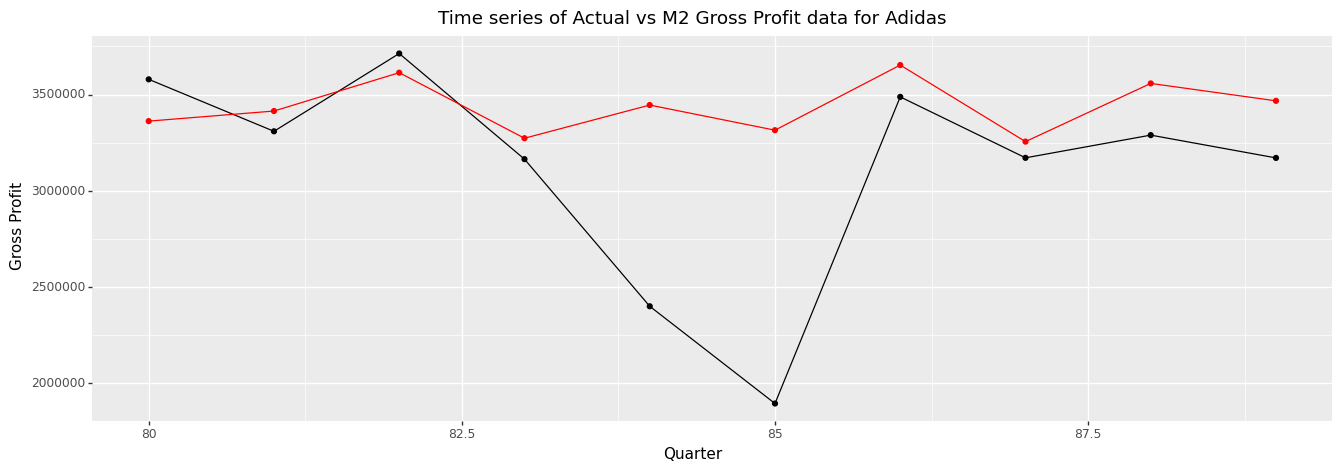

<ggplot: (8789823016105)>

In [ ]:
# Plotting actual COVID GP and predicted GP if COVID hadn't happened
# In order to assess if and/or when industry has recovered

# Adidas
(
    ggplot(df_a.loc[df_a['Quarter']>79],aes('Quarter','GrossProfit', group = 1)) + geom_point() + geom_line() +
 geom_point(aes('Quarter','M2a'), color='red') + geom_line(aes('Quarter','M2a'),color='red') + ggtitle("Time series of Actual vs M2 Gross Profit data for Adidas") +
  xlab("Quarter") + ylab("Gross Profit") + theme(figure_size=(16, 5))
)

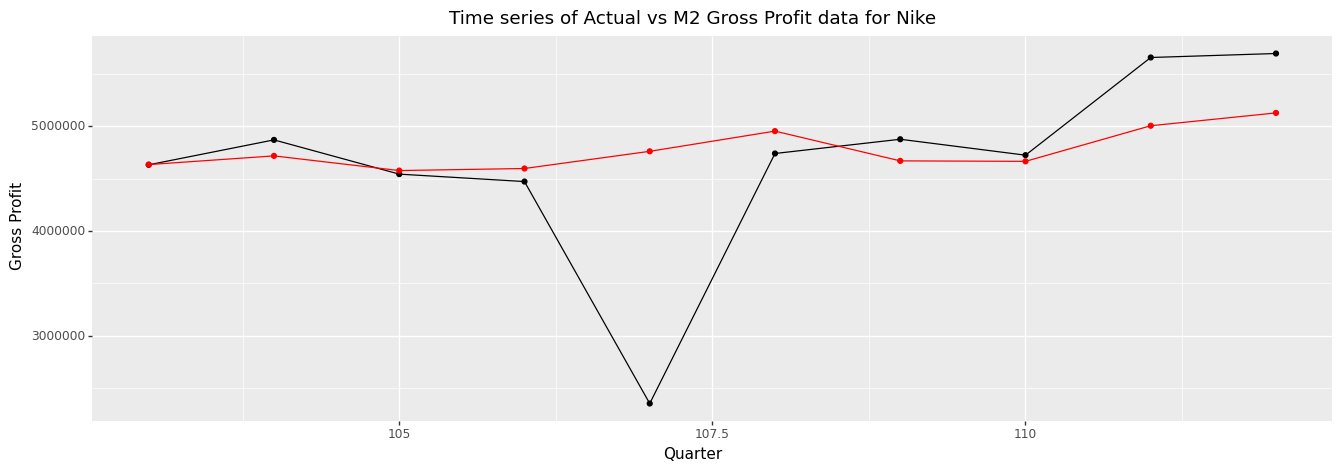

<ggplot: (8789822147021)>

In [ ]:
# Nike
(
    ggplot(df_n.loc[df_n['Quarter']>102],aes('Quarter','GrossProfit', group = 1)) + geom_point() + geom_line() +
 geom_point(aes('Quarter','M2n'), color='red') + geom_line(aes('Quarter','M2n'),color='red') + ggtitle("Time series of Actual vs M2 Gross Profit data for Nike") +
  xlab("Quarter") + ylab("Gross Profit") + theme(figure_size=(16, 5))
)